<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/changes/faceDetecting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка изображений

Подключим гугл-диск и из соответствующей папки загрузим необходимые данные. Хранить изображения (PIL Image) будем в словаре, ключом в котором будет имя файла.

In [1]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from google.colab import drive
from PIL import Image, ImageDraw

# подключение гугл-диска
drive.mount('/content/drive')

# сгрузим пути к данным в один массив
"""directories = ['/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_train.zip',
               '/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_test.zip',
               '/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_val.zip']"""
directories = [
    '/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_train.zip']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# распакуем архивы из гугл диска
z = []
for zips in directories:
    z.append(zipfile.ZipFile(zips, 'r'))

for archives in z:
    archives.extractall()


#list_dir= ['WIDER_test/images', 'WIDER_train/images', 'WIDER_val/images']
list_dir = ['WIDER_train/images']

In [3]:
# загружаем все изображения и конвертируем их в ч/б
def upload(directory):
    list_name = {}
    list_dirs = os.listdir(directory)
    for cur_dir in list_dirs:
        list_file = os.listdir(os.path.join(directory, cur_dir))
        for cur_file in list_file:
            img = Image.open(os.path.join(
                directory, cur_dir, cur_file)).convert("L")
            list_name[cur_file] = img
            if (len(list_name) == 6440):
                return list_name


train = upload(list_dir[0])
# test=upload(list_dir[1])
#val = upload(list_dir[2])

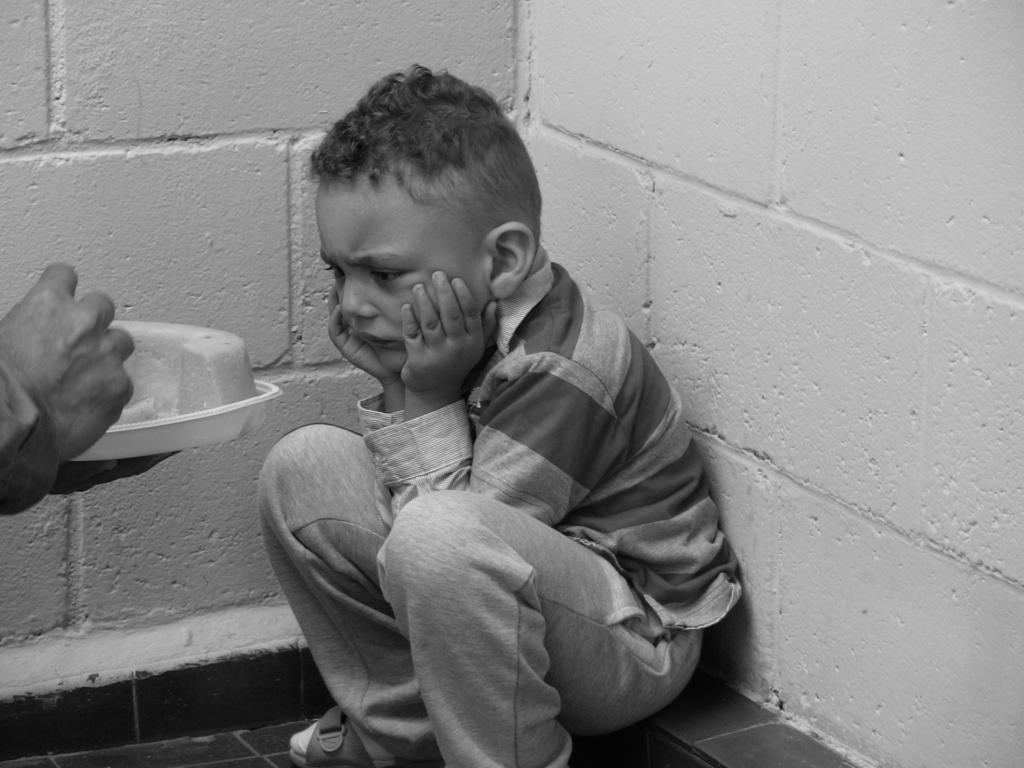

In [4]:
# выведем какое-нибудь изображение, чтобы убедиться, что загрузка прошла успешно
keys = train.keys()
keys_list = list(keys)
train[keys_list[19]]

#Загрузка рамок  
  В данном блоке осуществляется загрузка рамок с лицами. Для этого будем построчно читать txt файл, и если мы прочитали рамку(-и), к которой(-ым) у нас есть изображение, то загрузим их.

> The format of txt ground truth.  
File name  
Number of bounding box  
x1, y1, w, h, blur, expression, illumination,   invalid, occlusion, pose  

В случае если на изображении лиц нет, на вход будут поданы такие строки:

```
File name  
0  
0 0 0 0 0 0 0 0 0 0 
```


In [5]:
# загрузим рамки

Rectangle = namedtuple('Rectangle', 'x y w h')
frames = {}  # словарь Rectangle

# открываем нужный файлик
with open("/content/drive/My Drive/Курсач/files/wider_face_train_bbx_gt.txt", "r+") as file:
    for lines in file:
        # имя файла
        filename = lines.rstrip(' \n').split("/")[1]
        # число прямоугольников
        n = int(file.readline())
        rects = []
        # если прямоугольников нет, то в след.строке будет 0 0 0 0 0 0 0, это всё равно нужо как-то прочитать:)
        if n == 0:
            n += 1
        for elems in range(n):
            # для каждого прямоугольника загружаем все предложенные данные
            params = file.readline().rstrip(' \n').split(" ")
            params = params[:4]
            rects.append(Rectangle(int(params[0]), int(
                params[1]), int(params[2]), int(params[3])))
        # проверяем наличие нужного изображения в словаре изображений
        if filename in train:
            frames[filename] = rects

print(len(frames))

6440


#Формируем новые выборки на основе наших изображений

Бежим циклом по всем изображениям из train и вырезаем все лица по следующему правилу:


*   Если лицо есть, то вырезаем его. В качестве не лица берём прямоугольник такого же размера, местоположение - по диагонали от лица, т.е у изображений есть общая точка
*   Если лица нет, то в качестве не лица берём рандомное место. В моём случае это (300, 300, 300, 300)  
  
  
Приведение в одному размеру было таким, чтобы ни один признак не вышел за этот размер.  
Изменение размера шло по принципу Image.LANCZOS. Гугл сказал, что он даёт самое лучшее качество при изменении изображения (вроде там основа от метода k-ближайших соседей)



In [6]:
# делаем новые выборки

Faces = namedtuple('Faces', 'img is_face filename rect')
faces = []

MAXSIZE = (40, 40)
random_box = (300, 300, 300, 300)

for key in frames:
    for rect in frames[key]:
        if rect == (0, 0, 0, 0):
            img_not_face = train[key].crop(
                random_box).resize(MAXSIZE, Image.LANCZOS)
        else:
            img_face = train[key].crop(
                (rect.x, rect.y, rect.x + rect.w, rect.y + rect.h)).resize(MAXSIZE, Image.LANCZOS)
            img_not_face = train[key].crop(
                (rect.x + rect.w, rect.y + rect.h, rect.x + 2 * rect.w, rect.y + 2 * rect.h)).resize(MAXSIZE, Image.LANCZOS)

        faces.append(Faces(img_face, 1, key, rect))
        faces.append(Faces(img_not_face, 0, key, rect))


print(faces[0])

Faces(img=<PIL.Image.Image image mode=L size=40x40 at 0x7FB71F000278>, is_face=1, filename='0_Parade_marchingband_1_849.jpg', rect=Rectangle(x=449, y=330, w=122, h=149))


# Демонстрация изображений 
Давайте посмотрим пару изображений из новой выборки

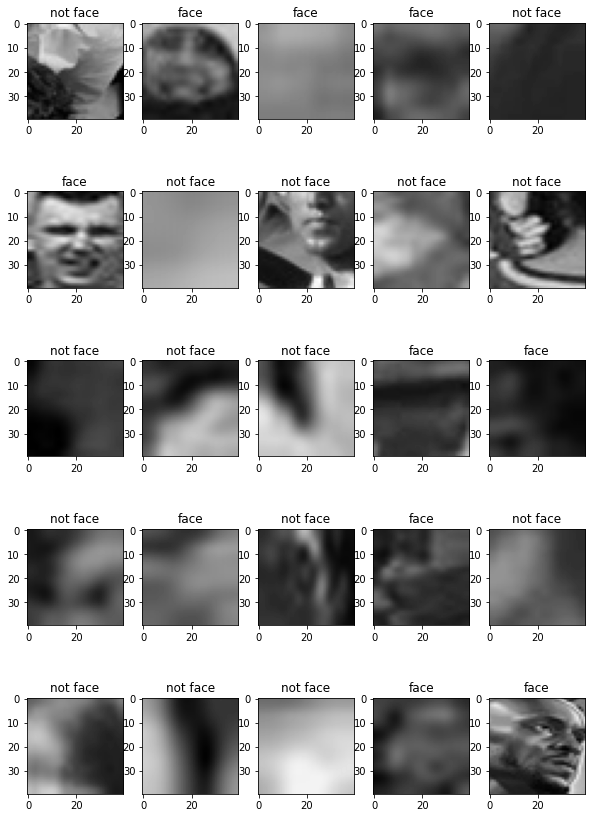

In [7]:
fig = plt.figure(figsize = (10, 15))
COLUMNS = 5
ROWS = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(COLUMNS * ROWS):
    rand_num = np.random.randint(0, len(faces))
    image = faces[rand_num].img
    # create subplot and append to ax
    ax.append(fig.add_subplot(ROWS, COLUMNS, i+1))
    if faces[rand_num].is_face == 1:
        ax[-1].set_title('face')  # set title
    else:
        ax[-1].set_title('not face')
    plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)

plt.show()  # finally, render the plot

# Катины заметки
У меня есть подозрение, что нам подсунули не самые качественные рамки для обучения, и теперь, как следствие, в наших данных слишком много шума:(  
Это очень хорошо видно, если позапускать код выше 5-10 раз. А давайте попробуем порисовать рамочки:) 

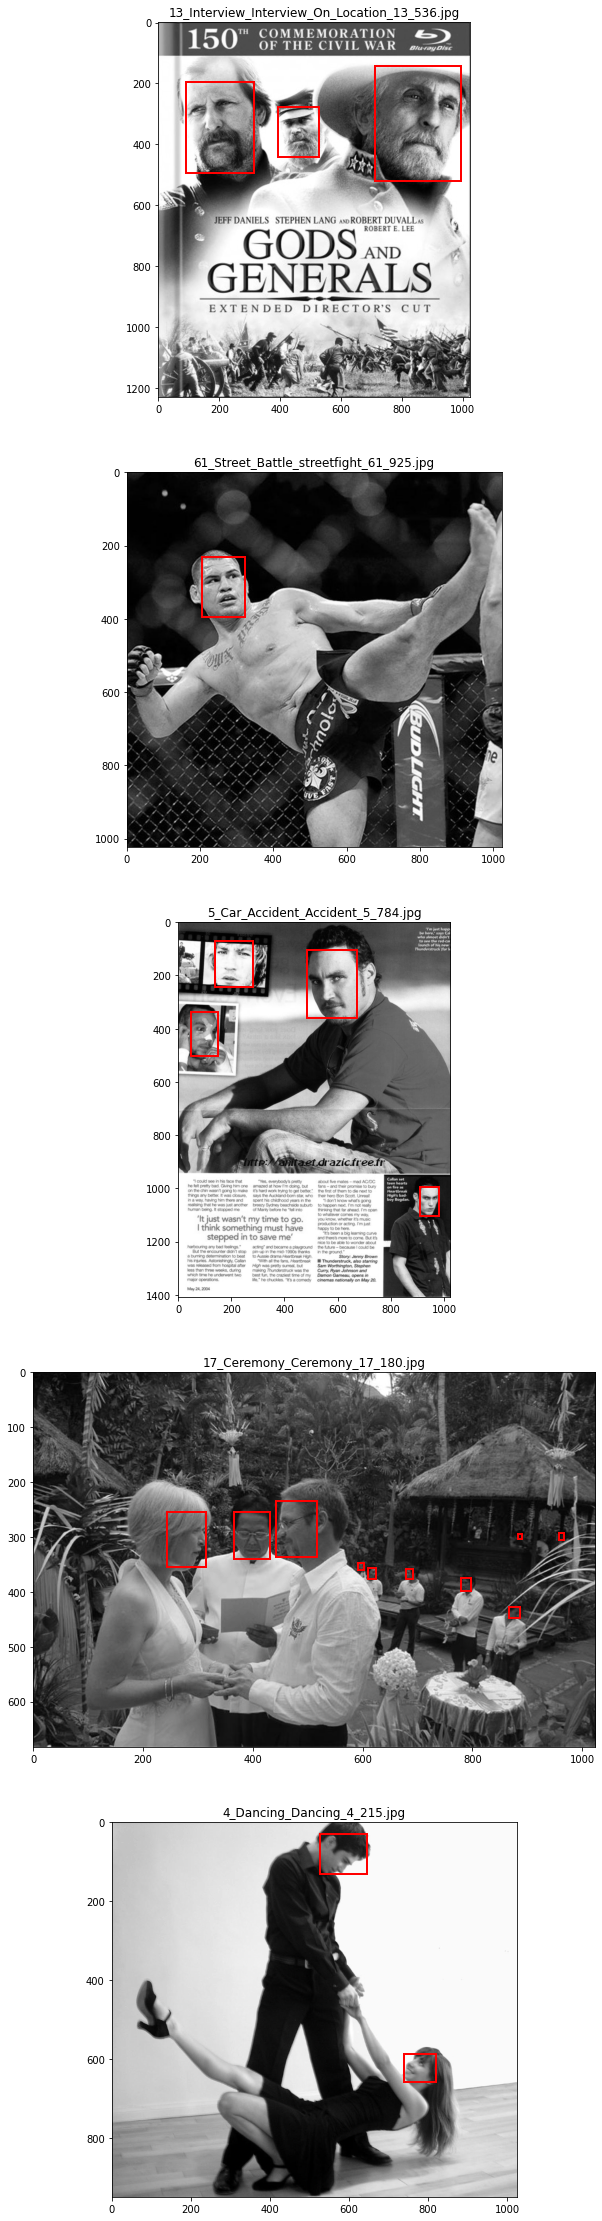

In [8]:
import matplotlib.patches as patches

fig = plt.figure(figsize = (30, 40))
COLUMNS = 1
ROWS = 5

# ax enables access to manipulate each of subplots
ax = []

for i in range(COLUMNS * ROWS):
    rand_num = np.random.randint(0, len(train))
    key = keys_list[rand_num]
    image = train[key]
    # create subplot and append to ax
    ax.append(fig.add_subplot(ROWS, COLUMNS, i + 1))
    for rect in frames[key]:
        rect = patches.Rectangle(
            (rect.x, rect.y), rect.w, rect.h, linewidth=2, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)
    ax[-1].set_title(key)  # set title
    plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)

plt.show()  # finally, render the plot

#Признаки Хоара

 Признаки я взяла из найденного раннее файла. Я скопировала n-строк, и там оказалось 109 признаков. 

 Формат хранения:
```
<features>  
  <_>
        <rects>
          <_>
            6 4 12 9 -1.</_>
          <_>
            6 7 12 3 3.</_></rects></_>
</features>
```
Представленный выше фрагмент описывает 1 признак Хоара, где прямоугольники задаются так:  
`<_> x1, y1, w, h, weight </_> `  
(верхний левый угол + ширина + высота + вес)  
  
более детальную информацию можно найти здесь:)  
https://api-2d3d-cad.com/viola-jones-method/

In [9]:
class HaarFeature:

    def __init__(self, rect_list):
        self.rect_list = rect_list

    def cacl_feature(self, cumsum_marix):
        f_X = 0
        for rects in self.rect_list:
            f_X += (cumsum_marix[rects.y - 1 + rects.h][rects.x - 1 + rects.w]
                    - cumsum_marix[rects.y - 1][rects.x - 1 + rects.w]
                    - cumsum_marix[rects.y - 1 + rects.h][rects.x - 1]
                    + cumsum_marix[rects.y - 1][rects.x - 1])*rects.weight
        return f_X

In [13]:
# займёмся признаками Хоара
from lxml import etree

h_features = []
HaarRect = namedtuple('HaarRect', 'x y w h weight')

# загрузим xml и распарсим его
with open('/content/drive/My Drive/Курсач/files/my_features.xml') as fobj:
    xml = fobj.read()
    root = etree.fromstring(xml)

    for elems in root.getchildren():
        for rects in elems.getchildren():
            rectangles = []
            for haar_rect in rects.getchildren():
                numbers = haar_rect.text[11:].split(" ")
                rectangles.append(HaarRect(int(numbers[0]), int(numbers[1]), int(
                    numbers[2]), int(numbers[3]), float(numbers[4])))
                # print(rec)
            h_features.append(HaarFeature(rectangles))
print(h_features[0].rect_list)

[HaarRect(x=6, y=4, w=12, h=9, weight=-1.0), HaarRect(x=6, y=7, w=12, h=3, weight=3.0)]


#Ищем фичи
В этом блоке формируется вектор признаков, который нам так нужен. Каким образом?  
Перемешаем наш массив картинок с лицами и без (на данный момент изображения идут примерно через один)
Далее бежим по новой выборке и для каждого изображения
переводим изображение в интегральное представление.

Один признак Хоара - это 2-3 прямоугольника. Я не знаю, стоит ли учитывать вес, тк в документации https://madebyollin.github.io/opencv-python-docs/#CascadeClassifier-detectMultiScale я нашла конструктор, который использую я. Но там нет ничего про вес. Однако есть конструктор с весами. Только вот я не поняла, там речь идёт про веса прямоугольников или про веса, так называемые sum_stage, которые являются значениями признаков и используются в каскадных классификаторах, чтобы проверять, прошли ли мы порог данного уровня или нет.  
Но при этом есть прямоугольники с положительными весами и с отрицательными, и я так понимаю, это что-то вроде градации на чёрное и белое (тк там где области накладываются, мы суммируем веса, а цвет опред.знаком). Если вес убрать, то нужно искать области, где прямоугольники накладываются друг на друга, поэтому я пока оставила всё с весами и просто суммирую все значения в рамках одного признака, умножив их на соответствующий вес.

In [29]:
# перемешаем выборку, подговим массив ответов, а также поделим всё на train  test
import random
import sklearn.model_selection as sk

random.seed(13)
random.shuffle(faces)

y = np.array(list(map(lambda x: int(x.is_face), faces)))
x_train, x_test, y_train, y_test = sk.train_test_split(faces, y, test_size=0.25, random_state=0)


print(x_test[0])

Faces(img=<PIL.Image.Image image mode=L size=40x40 at 0x7FB71C0CD908>, is_face=1, filename='20_Family_Group_Family_Group_20_709.jpg', rect=Rectangle(x=552, y=198, w=38, h=53))


In [35]:
# подготовим изображения для получения признаков на нём и посчитаем признаки
# формируем вектор признаков

def feature_creating(xz_kak_nazvat):
    haars_features = []
    matrix_features = []
    for images in xz_kak_nazvat:
      # интегральное представление изображения
      img = np.array(images.img, 'uint8')
      matrix_features.append(img.flatten())
      matrix = np.cumsum(img, axis=0)
      matrix = np.cumsum(matrix, axis=1)

      f_for_one_img = []
      for features in h_features:
          f_for_one_img.append(features.cacl_feature(matrix))
      haars_features.append(f_for_one_img)
    return np.array(haars_features), np.array(matrix_features)

haars_features_train, matrix_features_train = feature_creating(x_train)
haars_features_test, matrix_features_test = feature_creating(x_test)

print(len(haars_features_train))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in ulong_scalars
  if sys.path[0] == '':


96864


#Обучаем алгоритм
## и пробуем его применить

Теперь у нас есть всё, что необходимо для наших экспериментов. А значит мы можем заняться обучением и проверить, насколько хорошо наш алгоритм обучился:) 
Также я поняла, что нужно как-то проверить обученный алгоритм и посмотреть, насколько он силён в предсказаниях. А для этого нам нужна ещё выборка картинок. Поэтому разобьём наши faces на train и test. 
 


In [38]:
import sklearn.model_selection as sk
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


def face_detecting(x_train, x_test, y_train, y_test):
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # берём классификаторы

    logreg_classifier = LogisticRegression(random_state=42)
    randforest_classifier = RandomForestClassifier(random_state=42)
    tree_classifier = DecisionTreeClassifier(random_state=42)

    # для knn сперва поищем оптимальное число соседей
    """cv = sk.KFold(n_splits=5, random_state=42, shuffle=True)
  k_ = 0
  score_ = 0

  for k in range(1, 51):
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(x_train_scaled, y_train)
      score = np.mean(sk.cross_val_score(knn, x_train_scaled, y_train, cv=cv, scoring='accuracy'))

      if score > score_:
          score_ = score
          k_ = k"""

    #knn_classifier = KNeighborsClassifier(n_neighbors=5)

    # обучим классификаторы
    logreg_classifier.fit(x_train_scaled, y_train)
    randforest_classifier.fit(x_train_scaled, y_train)
    tree_classifier.fit(x_train_scaled, y_train)
    #knn_classifier.fit(x_train_scaled, y_train)

    # проверяем способность прогнозирования после обучения
    y_pred_logreg = logreg_classifier.predict(x_test_scaled)
    y_pred_randforest = randforest_classifier.predict(x_test_scaled)
    y_pred_tree = tree_classifier.predict(x_test_scaled)
    #y_pred_knn = knn_classifier.predict(x_test_scaled)

    return y_test, y_pred_logreg, y_pred_randforest, y_pred_tree

In [40]:
# подготовим данные для финального анализа
import pandas as pd

Methods = namedtuple('Methods', 'y_test logreg randforest tree')
answ = []
y_test, logreg, randforest, tree = face_detecting(haars_features_train, haars_features_test, y_train, y_test)
answ.append(Methods(y_test, logreg, randforest, tree))

print(answ[0])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Methods(y_test=array([1, 1, 0, ..., 0, 1, 1]), logreg=array([1, 1, 1, ..., 0, 1, 0]), randforest=array([1, 1, 0, ..., 0, 1, 1]), tree=array([1, 0, 0, ..., 0, 1, 1]))


In [41]:
# обучение частей временно разбито на 2 части для удобства отладки
y_test, logreg, randforest, tree = face_detecting(matrix_features_train, matrix_features_test, y_train, y_test)
answ.append(Methods(y_test, logreg, randforest, tree))
print(answ[1])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Methods(y_test=array([1, 1, 0, ..., 0, 1, 1]), logreg=array([1, 1, 1, ..., 0, 0, 0]), randforest=array([1, 1, 0, ..., 0, 1, 1]), tree=array([1, 1, 0, ..., 1, 1, 0]))


Может есть смысл делать несколько запусков для разных методов, тк иначе навесить на эту прогу ещё что-то вроде нового метода или бустинга будет крайне проблематично. Тот же knn требует больше ресурсов, чем я могу предоставить на данном этапе.

In [42]:
# визуация полученных значений для одного из признаков
answ = np.array(answ)
df = pd.DataFrame(columns=['y_test', 'logreg', 'randforest', 'tree'])
df['y_test'] = answ[0][0]
df['logreg'] = answ[0][1]
df['randforest'] = answ[0][2]
df['tree'] = answ[0][3]

df[:15]

,y_test,logreg,randforest,tree
0,1,1,1,1
1,1,1,1,0
2,0,1,0,0
3,1,1,1,1
4,0,0,0,0
5,0,0,0,1
6,1,0,0,1
7,1,0,0,0
8,0,0,0,0
9,1,1,1,0


# Результаты
Давайте немного проанализируем, что же у нас получилось.

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#cm = confusion_matrix(y_test, y_pred)
#print (cm)

# cm = [truePositive   falsePositive]
#      [falseNegative  trueNegative]

feature_list = ['Haars features', 'Matrix features']
methods_list = ['logreg', 'randforest', 'tree']

accuracy_df = pd.DataFrame(
    feature_list, index=['1', '2'], columns=['features'])


for n in range(1, 4):
    data = []
    for i, ans in enumerate(answ):
        data.append(accuracy_score(answ[i][0], answ[i][n]))
    accuracy_df[methods_list[n-1]] = data
    # print(data)

accuracy_df[:]

,features,logreg,randforest,tree
1,Haars features,0.662940,0.763937,0.662196
2,Matrix features,0.704039,0.802465,0.684991


#Блок-вопрос
Никак не могу понять, почему рамочки рисуются только после второго запуска:)
Т.е я запускаю первый раз и ничего не происходит, а потом запускаю этот же код ещё раз, и появляются рамочки.. 

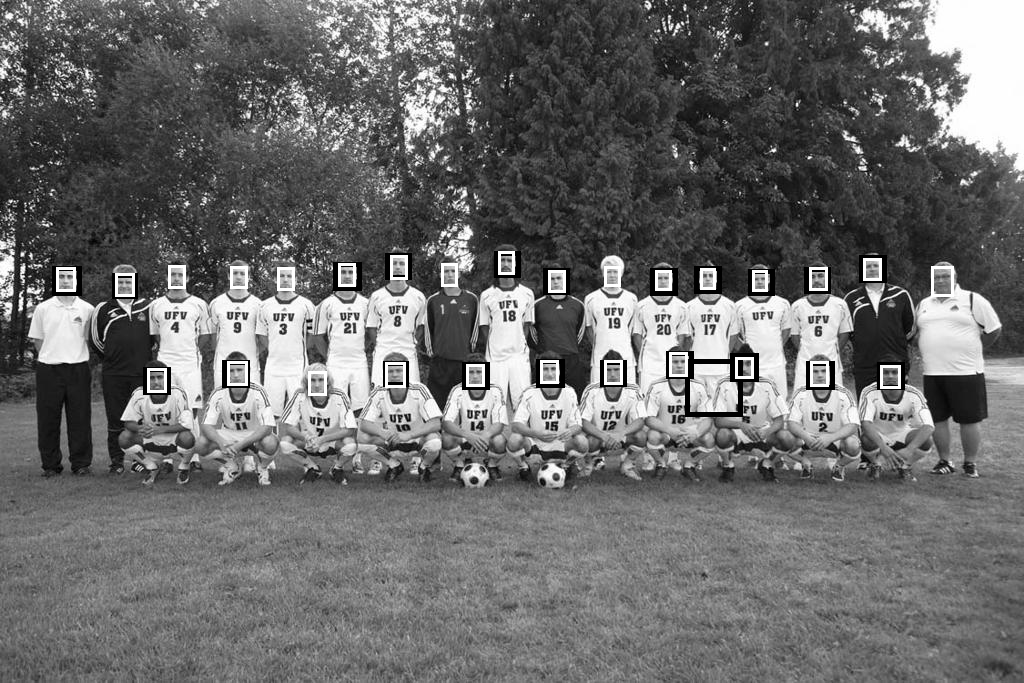

In [ ]:
# здесь можно просто поиграться:)
import matplotlib.pyplot as plt
faceCascade = cv2.CascadeClassifier(
    '/content/drive/My Drive/Курсач/files/haarcascade_frontalface_default.xml')

number = 2020
test_img = np.array(train[keys_list[number]], 'uint8')

idraw = ImageDraw.Draw(train[keys_list[number]])

# Детектим лица
faces = faceCascade.detectMultiScale(
    test_img, scaleFactor=1.1, minNeighbors=5, flags=cv2.CASCADE_SCALE_IMAGE)
# Для каждого найденного лица
for (x, y, w, h) in faces:
    # Рисуем красивые прямоугольнички
    idraw.rectangle((x, y, x + w, y + h), fill=None,  outline="black", width=5)


for rect in frames[keys_list[number]]:
    idraw.rectangle((rect.x, rect.y, rect.x + rect.w, rect.y +
                     rect.h), fill=None,  outline="white", width=3)


test_img = Image.fromarray(test_img)
test_img